# Classification

This is the file which loads the preprocessed data from the google big query and runs analysis to classify the data into airport staff/employee, passenger and devices.

Here we analyze the distribution of the data on the terminal and divide the data into 3 main classes:
<br />1) Airport Staff
<br />2) Passengers
<br />3) Devices
<br /> Hypothesis for classifying airport staff, passengers and devices:
<br />1) Any MacId that comes for >=17 days and <=24 days and for >=160 hrs and <=180 hrs a week are airport staff (Which is derived from the Labour Union law in Brazil).
<br />2) Any MacId less than 17 days is a passenger.
<br />3) Any MacId more than 24 days is a device in the terminal.
 

# Initialize Dependencies

In [ ]:
import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage_v1beta1
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import numpy as np
import datetime

# Setup Google BigQuery Client 

In [ ]:
credentials, your_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)
client = bigquery.Client.from_service_account_json('Team-Forseti-b8d019239b10.json')
bqstorageclient = bigquery_storage_v1beta1.BigQueryStorageClient(
    credentials=credentials
)

# Query Main Table - Terminal Level

In [ ]:
''' Query Main Table '''
main_sql = """
SELECT Distinct
  MacId,
  EXTRACT(DAYOFYEAR FROM Time) AS dayofyear,
  FROM `intense-wares-267520.T2_L1.T2_L1` order by dayofyear asc; """

query_job = client.query(main_aql)

## -----------------Uncomment to take a Pandaframe dump of above the result ------------------

main_df = (
    query_job.result().to_dataframe(bqstorage_client=bqstorageclient)
)


# Create Table From Query Result 

In [ ]:
table_name = 'intense-wares-267520.T2_L1.mac_daily_time'
sql1 = """SELECT DISTINCT
  MacId,
  EXTRACT(DAYOFYEAR FROM Time) AS dayofyear,
  EXTRACT(Time FROM Time) AS time,
  FROM `intense-wares-267520.T2_L1.T2_L1` order by time asc;"""

job_config = bigquery.QueryJobConfig(destination=table_name)
query_job = client.query(sql1, job_config=job_config)  # Make an API request.
query_job.result()


# BigQuery SQL - General

All of the data for this project is stored in the bigquery table beacuse of the sheer volume of the data. Bigquery is used to retrieve data from the database using the following sql statement


In [ ]:
sql1 = "SELECT Count(MacId) as counts, MacId FROM `intense-wares-267520.T2_L1.daily_mac` group by MacId"
sql2 = "SELECT Count(MacId) as counts, MacId FROM `intense-wares-267520.T2_L1.mac_monthly` group by MacId"
sql3 = "SELECT * FROM `intense-wares-267520.T2_L1.daily_mac` order by dayofyear asc"
df = client.query(sql3).result().to_dataframe(bqstorage_client=bqstorageclient)
#mac_monthly = client.query(sql2).result().to_dataframe(bqstorage_client=bqstorageclient)


In [ ]:
sql_time = "select * from `intense-wares-267520.T2_L1.mac_day_final_time`;"
df_time = client.query(sql_time).result().to_dataframe(bqstorage_client=bqstorageclient)

# Process Data Frame

In [ ]:
df_time.describe()
df_time.info()
df_time.head()


In [ ]:
df_time['diff_t']=(df_time['max_t']-df_time['min_t'])
df_time['diff_t'] = df_time['diff_t'].dt.total_seconds()
df_time.diff_t = df_time.diff_t.round()
df_time['month'] = df_time['max_t'].dt.month
df_time.head()
df_time.info()


In [ ]:

gb = df_time.groupby(['month'])
aug = gb.get_group(8)
sept = gb.get_group(9)
octo = gb.get_group(10)
nov = gb.get_group(11)
dec = gb.get_group(12)

# Derive data on Monthly basis

In [ ]:
final_dec = dec.groupby(["MacId"]).sum()
final_nov = nov.groupby(["MacId"]).sum()
final_octo = octo.groupby(["MacId"]).sum()
final_sept = sept.groupby(["MacId"]).sum()
final_aug = aug.groupby(["MacId"]).sum()


final_dec = dec.groupby("MacId",as_index=False).sum()
final_dec['dailycount'] = dec.groupby('MacId',as_index=False).count()['dayofyear']
final_dec['time_pday'] = final_dec['diff_t']/final_dec['dailycount']

final_nov = nov.groupby("MacId",as_index=False).sum()
final_nov['dailycount'] = nov.groupby('MacId',as_index=False).count()['dayofyear']
final_nov['time_pday'] = final_nov['diff_t']/final_nov['dailycount']


final_octo = octo.groupby("MacId",as_index=False).sum()
final_octo['dailycount'] = octo.groupby('MacId',as_index=False).count()['dayofyear']
final_octo['time_pday'] = final_octo['diff_t']/final_octo['dailycount']


final_sept = sept.groupby("MacId",as_index=False).sum()
final_sept['dailycount'] = sept.groupby('MacId',as_index=False).count()['dayofyear']
final_sept['time_pday'] = final_sept['diff_t']/final_sept['dailycount']


final_aug = aug.groupby("MacId",as_index=False).sum()
final_aug['dailycount'] = aug.groupby('MacId',as_index=False).count()['dayofyear']
final_aug['time_pday'] = final_aug['diff_t']/final_aug['dailycount']



In [ ]:
print(final_dec.describe())
print(final_nov.describe())
print(final_octo.describe())
print(final_sept.describe())
print(final_aug.describe())

# Airport Staff

In [ ]:
total = df_time.groupby("MacId",as_index=False).sum()
total['dailycount'] = df_time.groupby("MacId", as_index=False).count()['dayofyear']
total['time_pday'] = total['diff_t']/total['dailycount']

#### Any MacId that comes for >=17 days and <=24 days and for >=160 hrs and <=180 hrs a week are airport staff (Which is derived from the Labour Union law in Brazil).

Text(0.5, 0, 'Time_Per_Day: August')

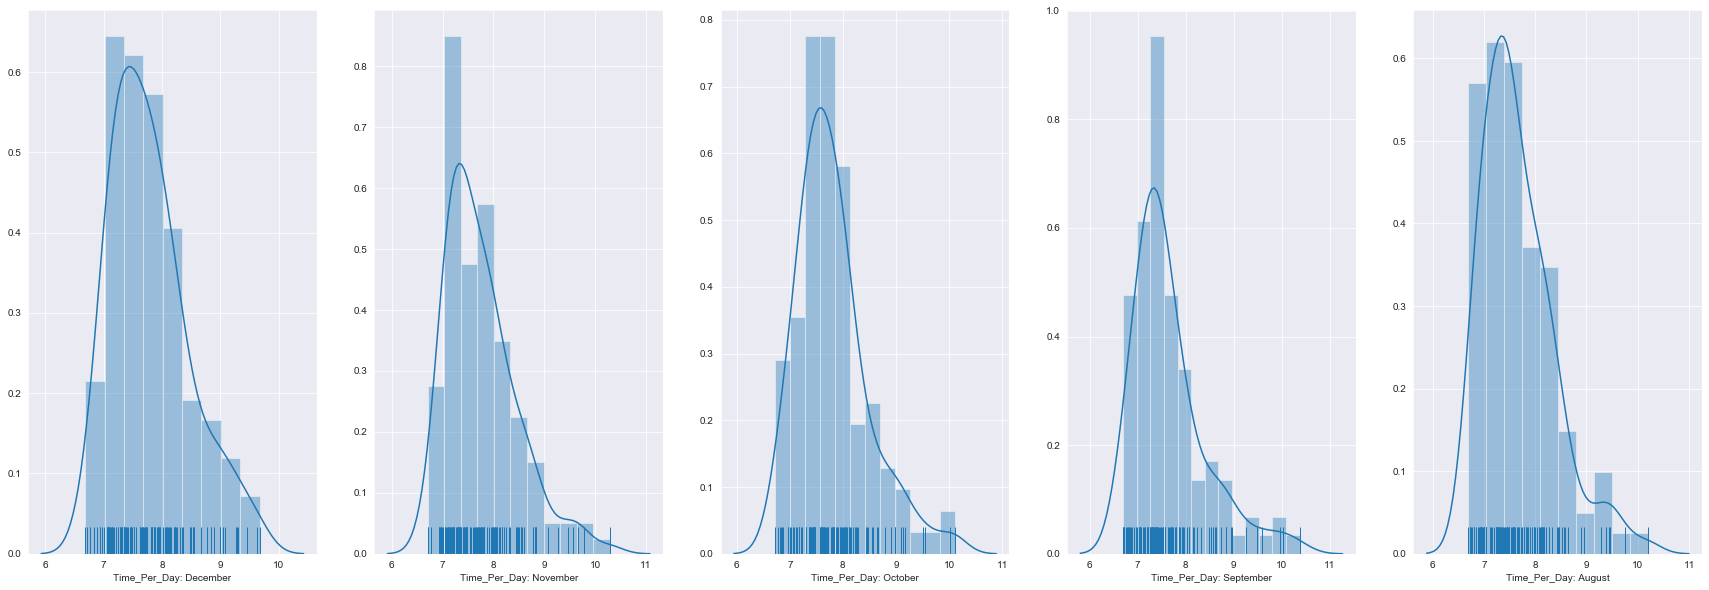

In [618]:
fig, ax1 = plt.subplots(figsize=(30, 10))
plt.subplot(151)
sns.distplot(final_dec[((final_dec['diff_t']/3600>160)&(final_dec['diff_t']/3600<180)&(final_dec['dailycount']>=17)&(final_dec['dailycount']<=24))]['time_pday']/3600,rug=True)
plt.xlabel('Time_Per_Day: December')

plt.subplot(152)
sns.distplot(final_nov[((final_nov['diff_t']/3600>160)&(final_nov['diff_t']/3600<180)&(final_nov['dailycount']>=17)&(final_nov['dailycount']<=24))]['time_pday']/3600,rug=True)
plt.xlabel('Time_Per_Day: November')

plt.subplot(153)
sns.distplot(final_octo[((final_octo['diff_t']/3600>160)&(final_octo['diff_t']/3600<180)&(final_octo['dailycount']>=17)&(final_octo['dailycount']<=24))]['time_pday']/3600,rug=True)
plt.xlabel('Time_Per_Day: October')

plt.subplot(154)
sns.distplot(final_sept[((final_sept['diff_t']/3600>160)&(final_sept['diff_t']/3600<180)&(final_sept['dailycount']>=17)&(final_sept['dailycount']<=24))]['time_pday']/3600,rug=True)
plt.xlabel('Time_Per_Day: September')

plt.subplot(155)
sns.distplot(final_aug[((final_aug['diff_t']/3600>160)&(final_aug['diff_t']/3600<180)&(final_aug['dailycount']>=17)&(final_aug['dailycount']<=24))]['time_pday']/3600,rug=True)
plt.xlabel('Time_Per_Day: August')







A very strong relationship with the hypothesis can be seen from the distribution

In [ ]:
final_dec[((final_dec['diff_t']/3600>160)&(final_dec['diff_t']/3600<180)&(final_dec['dailycount']>=17)&(final_dec['dailycount']<=24))]['MacId']

In [619]:
print(final_dec[((final_dec['diff_t']/3600>160)&(final_dec['diff_t']/3600<180)&(final_dec['dailycount']>=17)&(final_dec['dailycount']<=24))].describe())
print(final_nov[((final_nov['diff_t']/3600>160)&(final_nov['diff_t']/3600<180)&(final_nov['dailycount']>=17)&(final_nov['dailycount']<=24))].describe())
print(final_octo[((final_octo['diff_t']/3600>160)&(final_octo['diff_t']/3600<180)&(final_octo['dailycount']>=17)&(final_octo['dailycount']<=24))].describe())
print(final_sept[((final_sept['diff_t']/3600>160)&(final_sept['diff_t']/3600<180)&(final_sept['dailycount']>=17)&(final_sept['dailycount']<=24))].describe())
print(final_aug[((final_aug['diff_t']/3600>160)&(final_aug['diff_t']/3600<180)&(final_aug['dailycount']>=17)&(final_aug['dailycount']<=24))].describe())









         dayofyear         diff_t       month  dailycount     time_pday
count   126.000000     126.000000  126.000000  126.000000    126.000000
mean   7665.626984  612142.968254  263.428571   21.952381  28047.523484
std     584.793786   21632.565821   19.898715    1.658226   2392.344201
min    5880.000000  576456.000000  204.000000   17.000000  24055.083333
25%    7328.000000  592425.500000  252.000000   21.000000  26282.651515
50%    7689.500000  612786.000000  264.000000   22.000000  27660.142857
75%    8049.750000  631432.250000  276.000000   23.000000  29350.284091
max    8427.000000  647820.000000  288.000000   24.000000  34824.500000
         dayofyear         diff_t       month  dailycount     time_pday
count   123.000000     123.000000  123.000000  123.000000    123.000000
mean   6989.829268  606897.569106  240.569106   21.869919  27928.431114
std     539.094653   19708.085436   18.629292    1.693572   2500.843078
min    5349.000000  576883.000000  187.000000   17.000000  24144

# Devices

#### Any MacId more than 24 days is a device in the terminal.

Text(0.5, 0, 'Time_Per_Day: August')

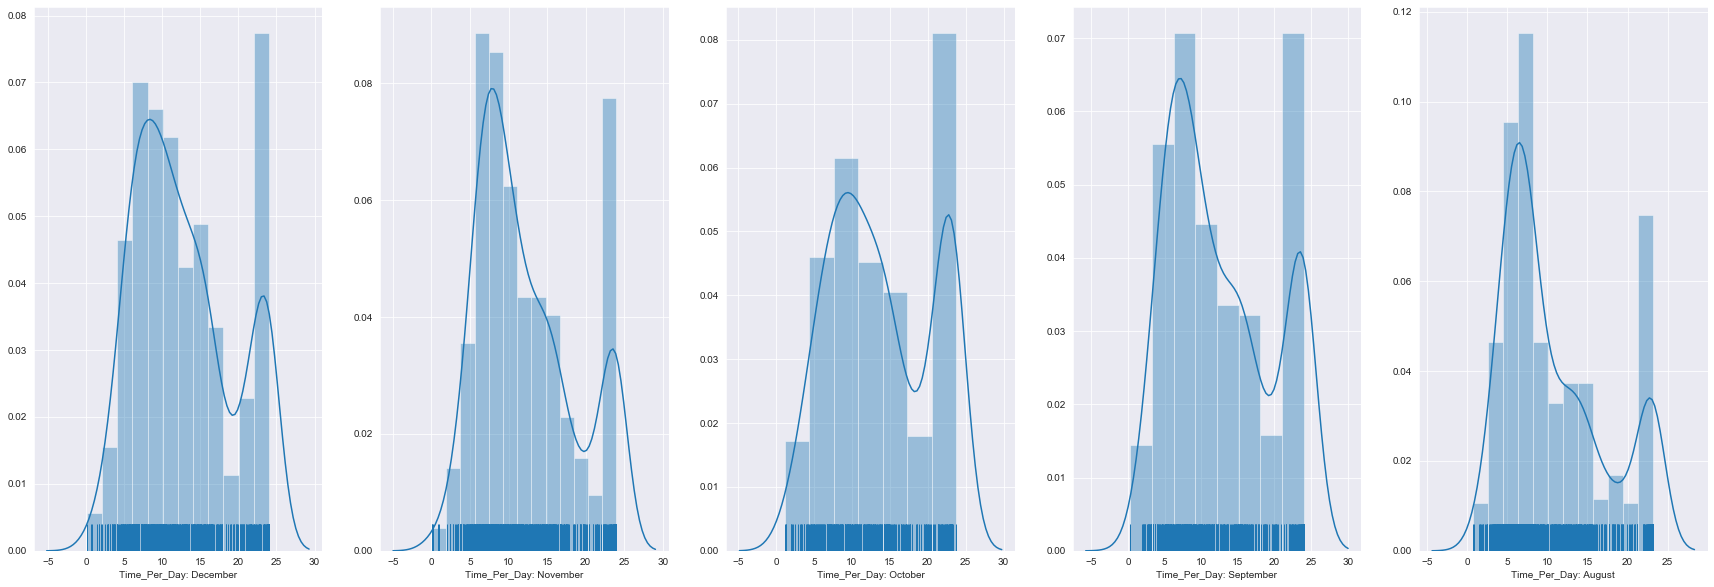

In [620]:
fig, ax1 = plt.subplots(figsize=(30, 10))
plt.subplot(151)
sns.distplot(final_dec[(final_dec['dailycount']>=25)]['time_pday']/3600,rug=True)
plt.xlabel('Time_Per_Day: December')

plt.subplot(152)
sns.distplot(final_nov[(final_nov['dailycount']>=25)]['time_pday']/3600,rug=True)
plt.xlabel('Time_Per_Day: November')

plt.subplot(153)
sns.distplot(final_octo[(final_octo['dailycount']>=25)]['time_pday']/3600,rug=True)
plt.xlabel('Time_Per_Day: October')

plt.subplot(154)
sns.distplot(final_sept[(final_sept['dailycount']>=25)]['time_pday']/3600,rug=True)
plt.xlabel('Time_Per_Day: September')

plt.subplot(155)
sns.distplot(final_aug[(final_aug['dailycount']>=25)]['time_pday']/3600,rug=True)
plt.xlabel('Time_Per_Day: August')







In [621]:
print(final_dec[(final_dec['dailycount']>=25)].describe())
print(final_nov[(final_nov['dailycount']>=25)].describe())
print(final_octo[(final_octo['dailycount']>=25)].describe())
print(final_sept[(final_sept['dailycount']>=25)].describe())
print(final_aug[(final_aug['dailycount']>=25)].describe())









          dayofyear        diff_t       month  dailycount     time_pday
count    616.000000  6.160000e+02  616.000000  616.000000    616.000000
mean    9668.525974  1.305629e+06  332.025974   27.668831  46143.241428
std      666.078442  7.131145e+05   22.842536    1.903545  22947.822911
min     8691.000000  7.893000e+03  300.000000   25.000000    292.333333
25%     9078.000000  7.174132e+05  312.000000   26.000000  27526.536681
50%     9772.000000  1.130976e+06  336.000000   28.000000  41757.620741
75%    10485.000000  1.759619e+06  360.000000   30.000000  59999.441092
max    10485.000000  2.591636e+06  360.000000   30.000000  86387.866667
         dayofyear        diff_t       month  dailycount     time_pday
count   687.000000  6.870000e+02  687.000000  687.000000    687.000000
mean   8774.377001  1.237752e+06  302.043668   27.458515  44054.640462
std     620.332058  6.953642e+05   21.392578    1.944780  22391.907682
min    7925.000000  7.750000e+03  275.000000   25.000000    276.7857

# Passengers

#### Any MacId less than 17 days is a passenger.

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 10))
plt.subplot(151)
sns.distplot(final_dec[(final_dec['dailycount']<16)]['time_pday']/3600,rug=True)
plt.xlabel('Time_Per_Day: December')

plt.subplot(152)
sns.distplot(final_nov[(final_nov['dailycount']<16)]['time_pday']/3600,rug=True)
plt.xlabel('Time_Per_Day: November')

plt.subplot(153)
sns.distplot(final_octo[(final_octo['dailycount']<16)]['time_pday']/3600,rug=True)
plt.xlabel('Time_Per_Day: October')

plt.subplot(154)
sns.distplot(final_sept[(final_sept['dailycount']<16)]['time_pday']/3600,rug=True)
plt.xlabel('Time_Per_Day: September')

plt.subplot(155)
sns.distplot(final_aug[(final_aug['dailycount']<16)]['time_pday']/3600,rug=True)
plt.xlabel('Time_Per_Day: August')


In [ ]:
print(final_dec[(final_dec['dailycount']<=16)].describe())
print(final_nov[(final_nov['dailycount']<=16)].describe())
print(final_octo[(final_octo['dailycount']<=16)].describe())
print(final_sept[(final_sept['dailycount']<=16)].describe())
print(final_aug[(final_aug['dailycount']<=16)].describe())

# Save to csv

In [ ]:
final_dec[(final_dec['dailycount']>=25)]['MacId'].to_csv('device_L3.csv', sep = ',',index=False,mode='a')

